In [2]:
import torch
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import gc
import os


# 시각화 관련 설정
try:
    plt.rcParams['font.family'] = 'Apple SD Gothic Neo'
except:
    try:
        plt.rcParams['font.family'] = 'NanumGothic'
    except:
        plt.rcParams['font.family'] = 'AppleGothic'

plt.rcParams['axes.unicode_minus'] = False
fm._load_fontmanager(try_read_cache=False)


# 디바이스 설정
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    DEVICE = torch.device("mps") # 맥 GPU
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda:0") # 윈도우 GPU
else:
    DEVICE = torch.device("cpu") # CPU


# 캐시 지우기 함수 생성
def clean_cache():
    gc.collect()
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        torch.mps.empty_cache()
    elif torch.cuda.is_available():
        torch.cuda.empty_cache()

# MallocStackLogging 에러 출력 방지
os.environ.pop("MallocStackLogging", None)
os.environ.pop("MallocStackLoggingNoCompact", None)
os.environ.pop("DYLD_INSERT_LIBRARIES", None)


# # 로그
# import logging

# def init_logger() -> logging.Logger:
#     logging.basicConfig(
#         format="%(asctime)s [%(levelname)s] (%(filename)s:%(lineno)d) - %(message)s",
#         datefmt="%Y-%m-%d %H:%M:%S",
#         level=logging.INFO,
#         encoding="utf-8",
#     )
#     return logging.getLogger("")

# logger = init_logger()

Matplotlib is building the font cache; this may take a moment.


In [ ]:
import json

ROOT_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(ROOT_DIR, "data")
IMAGE_DIR = os.path.join(DATA_DIR, "train_images")
ANNOT_DIR = os.path.join(DATA_DIR, "train_annotations")

full_dict_path = os.path.join(DATA_DIR, "FULL_DICT.json")
err_txt_path = os.path.join(DATA_DIR, "err_image_paths.txt")
fixed_dict_path = os.path.join(DATA_DIR, "FIXED_DICT.json")

FINAL_DICT = {}

# FULL_DICT 더하기
try:
    with open(full_dict_path, "r", encoding="utf-8") as f:
        FULL_DICT = json.load(f)
except:
    pass

for key, value in FULL_DICT.items():
    a = os.path.join(IMAGE_DIR, key)
    tmp_list = []
    for pa in value:
        tmp_list.append(os.path.join(ANNOT_DIR, pa))
    FINAL_DICT[a] = tmp_list


# err_image_paths 빼기
try:
    with open(err_txt_path, "r", encoding="utf-8") as f:
        err_image_paths = f.read().split()
    for err in err_image_paths:
        a = os.path.join(IMAGE_DIR, err)
        del FINAL_DICT[a]
except:
    pass


# FIXED_DICT 더하기
try:
    with open(fixed_dict_path, "r", encoding="utf-8") as f:
        FIXED_DICT = json.load(f)
    for key, value in FIXED_DICT:
        a = os.path.join(IMAGE_DIR, key)
        tmp_list = []
        for pa in value:
            tmp_list.append(os.path.join(ANNOT_DIR, pa))
        FINAL_DICT[a] = tmp_list
except:
    pass


for image_path, annot_paths in FINAL_DICT.items():

    tmp_list = []

    for path in annot_paths:
        bbox = []
        with open(path, "r", encoding="utf-8") as f:
            json_data = json.load(f)

        xywh_bbox = json_data["annotations"][0]["bbox"]

        tmp_list.append({"bbox": xywh_bbox,
                        "label": json_data["categories"][0]["id"]})
        
    FINAL_DICT[image_path] = tmp_list

215

In [19]:
# from torch.utils.data import Dataset, DataLoader
# import torchvision.transforms as transforms

# class PillDataset(Dataset):
#     def __init__(self):
#         self.images = FULL_IMAGE_PATHS
#         self.path = FINAL_DICT

#     def __len__(self):
#         return len(FINAL_DICT)

#     def __getitem__(self, index):
#         image = self.images[index]
#         annots = self.path[image]
        
#         target = {}
#         target["boxes"] = [annot["bbox"] for annot in annots]
#         target["labels"] = [annot["label"] for annot in annots]
        
#         return image, target

# TRAIN_DATASET = PillDataset()

In [20]:
# def collate_fn(batch):
#     return tuple(zip(*batch))

# TRAIN_DATALOADER = DataLoader(TRAIN_DATASET, batch_size=4, collate_fn=(lambda batch: tuple(zip(*batch))))

In [ ]:
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image

# YOLO 데이터셋 폴더 생성
YOLO_BASE_PATH = "./data/yolo_dataset"
os.makedirs(f"{YOLO_BASE_PATH}/images/train", exist_ok=True)
os.makedirs(f"{YOLO_BASE_PATH}/images/val", exist_ok=True)
os.makedirs(f"{YOLO_BASE_PATH}/labels/train", exist_ok=True)
os.makedirs(f"{YOLO_BASE_PATH}/labels/val", exist_ok=True)

# 클래스 ID 매핑 생성 (category id -> 0부터 시작하는 인덱스)
unique_labels = set()
for annots in FINAL_DICT.values():
    for annot in annots:
        unique_labels.add(annot["label"])

label_to_idx = {label: idx for idx, label in enumerate(sorted(unique_labels))}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

print(f"총 클래스 수: {len(label_to_idx)}")
print(f"클래스 매핑: {label_to_idx}")

# Train/Val 분할 (80:20)
image_paths = list(FINAL_DICT.keys())
train_images, val_images = train_test_split(image_paths, test_size=0.2, random_state=42)

print(f"\nTrain 이미지: {len(train_images)}개")
print(f"Val 이미지: {len(val_images)}개")

def convert_to_yolo_format(bbox, img_width, img_height):
    """
    XYXY bbox를 YOLO format (normalized XYWH)으로 변환
    Args:
        bbox: [x1, y1, x2, y2]
        img_width, img_height: 이미지 크기
    Returns:
        [x_center, y_center, width, height] (normalized)
    """
    x, y, w, h = bbox
    
    # 중심점과 너비/높이 계산
    x_center = x + w/2
    y_center = y + h/2
    width = w
    height = h
    
    # 정규화 (0~1 범위)
    x_center /= img_width
    y_center /= img_height
    width /= img_width
    height /= img_height
    
    return [x_center, y_center, width, height]

def create_yolo_labels(image_paths, split='train'):
    """YOLO 라벨 파일 생성 및 이미지 복사"""
    for img_path in image_paths:
        # 이미지 크기 읽기
        img = Image.open(img_path)
        img_width, img_height = img.size
        
        # 이미지 파일명
        img_filename = os.path.basename(img_path)
        img_name = os.path.splitext(img_filename)[0]
        
        # 이미지 복사
        dst_img_path = f"{YOLO_BASE_PATH}/images/{split}/{img_filename}"
        shutil.copy(img_path, dst_img_path)
        
        # 라벨 파일 생성
        label_path = f"{YOLO_BASE_PATH}/labels/{split}/{img_name}.txt"
        
        with open(label_path, 'w') as f:
            annots = FINAL_DICT[img_path]
            for annot in annots:
                # 클래스 ID 변환
                class_id = label_to_idx[annot["label"]]
                
                # bbox를 YOLO 형식으로 변환
                yolo_bbox = convert_to_yolo_format(
                    annot["bbox"], 
                    img_width, 
                    img_height
                )
                
                # YOLO 형식으로 작성: <class> <x_center> <y_center> <width> <height>
                f.write(f"{class_id} {' '.join(map(str, yolo_bbox))}\n")

# Train/Val 라벨 생성
print("\n라벨 파일 생성 중...")
create_yolo_labels(train_images, 'train')
create_yolo_labels(val_images, 'val')
print("완료!")

# YOLO data.yaml 파일 생성
data_yaml = {
    'path': os.path.abspath(YOLO_BASE_PATH),  # 데이터셋 루트 경로
    'train': 'images/train',  # train 이미지 경로
    'val': 'images/val',      # val 이미지 경로
    'nc': len(label_to_idx),  # 클래스 개수
    'names': idx_to_label     # 클래스 이름 (idx: label)
}

import yaml
with open(f"{YOLO_BASE_PATH}/data.yaml", 'w', encoding='utf-8') as f:
    yaml.dump(data_yaml, f, default_flow_style=False, allow_unicode=True, sort_keys=False)

print(f"\nYOLO 데이터셋 준비 완료!")
print(f"경로: {YOLO_BASE_PATH}")
print(f"data.yaml 생성 완료")


총 클래스 수: 56
클래스 매핑: {1899: 0, 2482: 1, 3350: 2, 3482: 3, 3543: 4, 3742: 5, 3831: 6, 4542: 7, 12080: 8, 12246: 9, 12777: 10, 13394: 11, 13899: 12, 16231: 13, 16261: 14, 16547: 15, 16550: 16, 16687: 17, 18146: 18, 18356: 19, 19231: 20, 19551: 21, 19606: 22, 19860: 23, 20013: 24, 20237: 25, 20876: 26, 21324: 27, 21770: 28, 22073: 29, 22346: 30, 22361: 31, 24849: 32, 25366: 33, 25437: 34, 25468: 35, 27732: 36, 27776: 37, 27925: 38, 27992: 39, 28762: 40, 29344: 41, 29450: 42, 29666: 43, 30307: 44, 31862: 45, 31884: 46, 32309: 47, 33008: 48, 33207: 49, 33879: 50, 34596: 51, 35205: 52, 36636: 53, 38161: 54, 41767: 55}

Train 이미지: 176개
Val 이미지: 44개

라벨 파일 생성 중...
완료!

YOLO 데이터셋 준비 완료!
경로: ./data/yolo_dataset
data.yaml 생성 완료


In [37]:
# import os
# import torch
# from ultralytics import YOLO

# MODEL_NAME = "yolov8n.pt"

# model = YOLO(MODEL_NAME)

# DATA_PATH = "./data/yolo_dataset/data.yaml"

# if not os.path.exists(DATA_PATH):
#     raise FileNotFoundError(
#         f"data.yaml 파일을 찾을 수 없음"
#     )

# with open(DATA_PATH, "r") as f:
#     yaml_content = f.read()
#     print("data.yaml 내용 미리보기:\n")
#     print(yaml_content[:400])  # 너무 길면 앞부분만 보여줌


# required_dirs = [
#     "./data/yolo_dataset/images/train"
#     "./data/yolo_dataset/images/val"
#     "./data/yolo_dataset/labels/train"
#     "./data/yolo_dataset/labels/val"
# ]

# results = model.train(
#     data="./dataset/data.yaml",
#     epochs=50,
#     imgsz=640,
#     batch=16,
#     device=0,         # GPU
#     project="runs/pill",
#     name="y8n_baseline",
# )

In [38]:
from ultralytics import YOLO

# YOLO 모델 로드 (사전학습된 모델)
model = YOLO('yolov8n.pt')  # nano 모델 (yolov8s.pt, yolov8m.pt 등으로 변경 가능)

# 학습
results = model.train(
    data=f'{YOLO_BASE_PATH}/data.yaml',
    epochs=30,
    imgsz=640,
    batch=16,
    name='pill_detection',
    device=DEVICE,  # 'mps', 'cuda', 'cpu'
)

# 검증
metrics = model.val()

# 추론 테스트
results = model.predict(
    source=f'{YOLO_BASE_PATH}/images/val',
    save=True,
    conf=0.25
)

New https://pypi.org/project/ultralytics/8.3.235 available 😃 Update with 'pip install -U ultralytics'
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./data/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pill_detection4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspe

KeyboardInterrupt: 

파일 없음: ./runs/detect/pill_detection/results.png
파일 없음: ./runs/detect/pill_detection/confusion_matrix.png
파일 없음: ./runs/detect/pill_detection/F1_curve.png
파일 없음: ./runs/detect/pill_detection/P_curve.png
파일 없음: ./runs/detect/pill_detection/R_curve.png
파일 없음: ./runs/detect/pill_detection/PR_curve.png


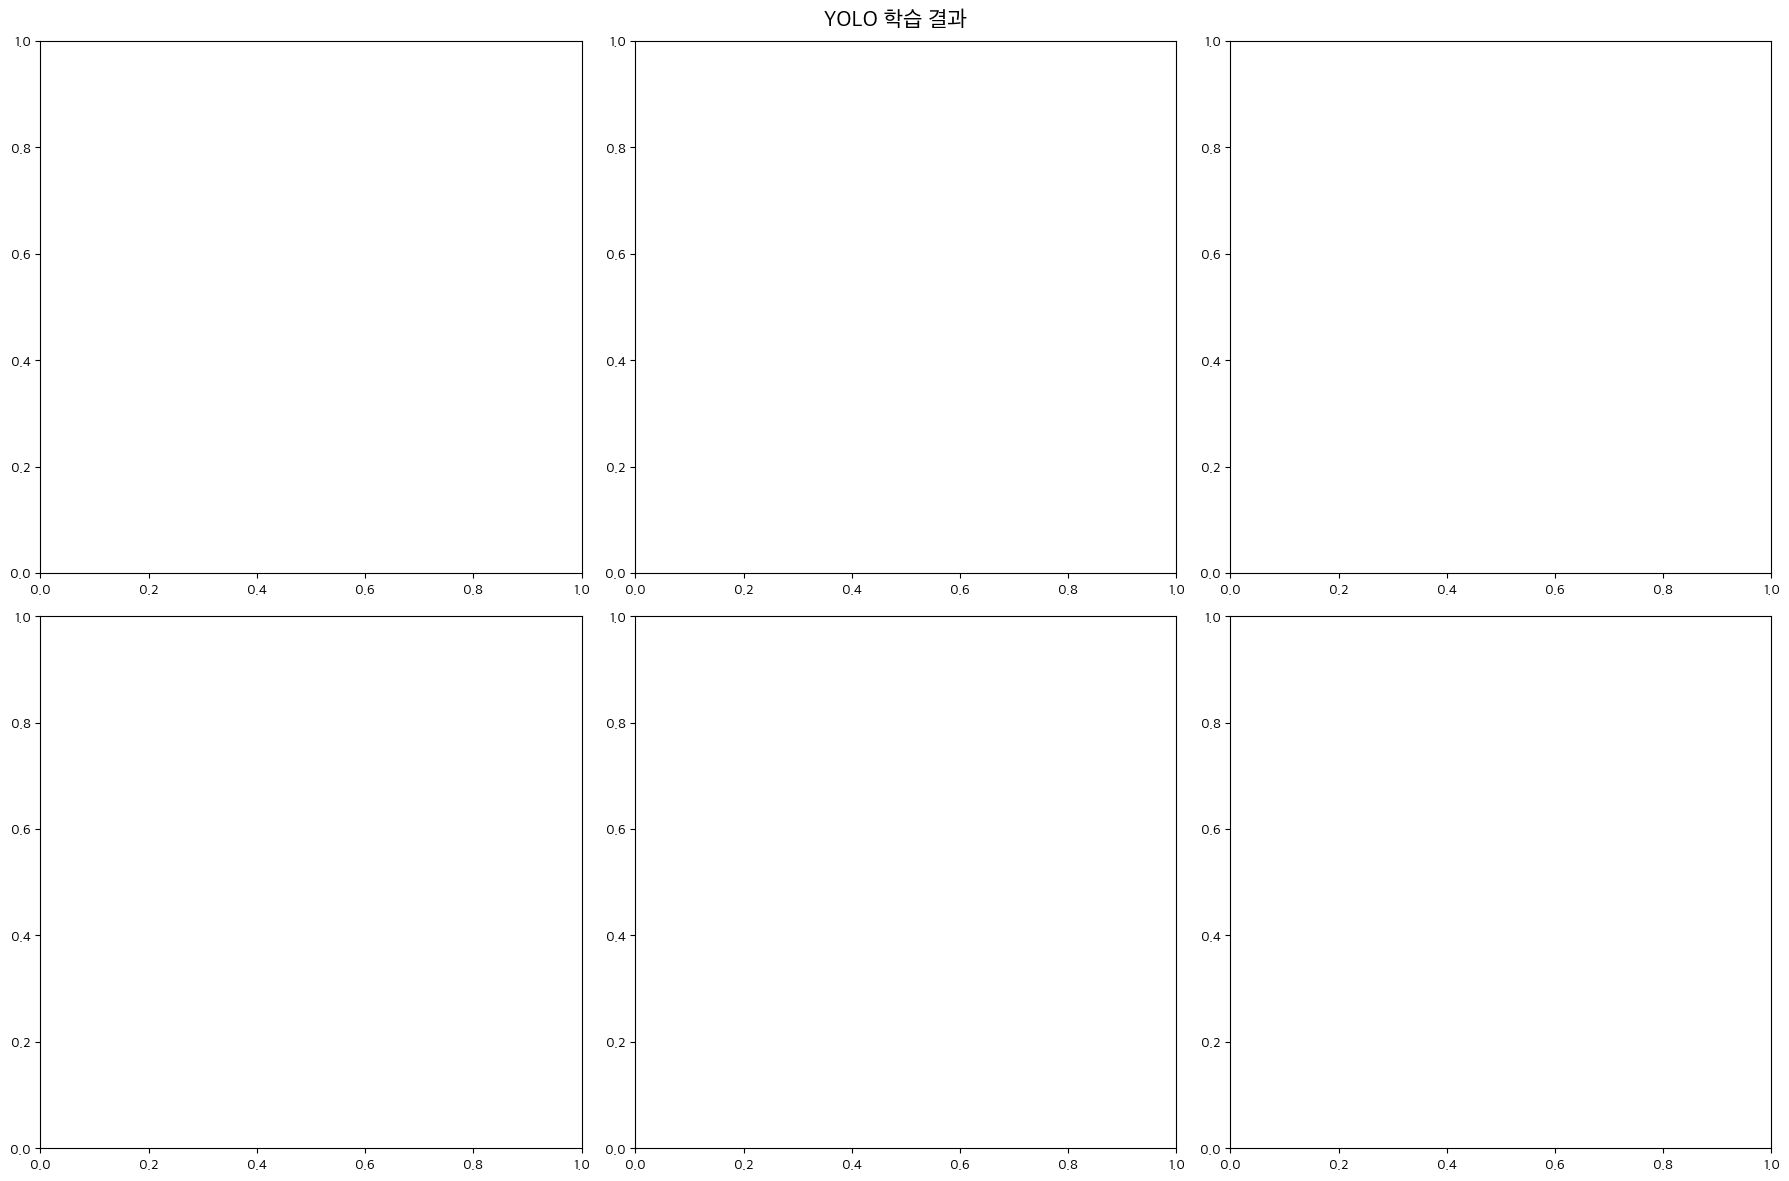

In [ ]:
# 학습 결과 그래프 표시
def show_training_results(project_name='pill_detection'):
    """학습 결과 그래프 출력"""
    results_path = f'./runs/detect/{project_name}'
    
    # 학습 메트릭 이미지들
    metric_images = ['results.png', 'confusion_matrix.png', 'F1_curve.png', 
                     'P_curve.png', 'R_curve.png', 'PR_curve.png']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('YOLO 학습 결과', fontsize=16, fontweight='bold')
    
    for idx, img_name in enumerate(metric_images):
        img_path = f'{results_path}/{img_name}'
        if os.path.exists(img_path):
            img = Image.open(img_path)
            ax = axes[idx // 3, idx % 3]
            ax.imshow(img)
            ax.set_title(img_name.replace('.png', '').replace('_', ' ').title())
            ax.axis('off')
        else:
            print(f"파일 없음: {img_path}")
    
    plt.tight_layout()
    plt.show()

# 실행
show_training_results()

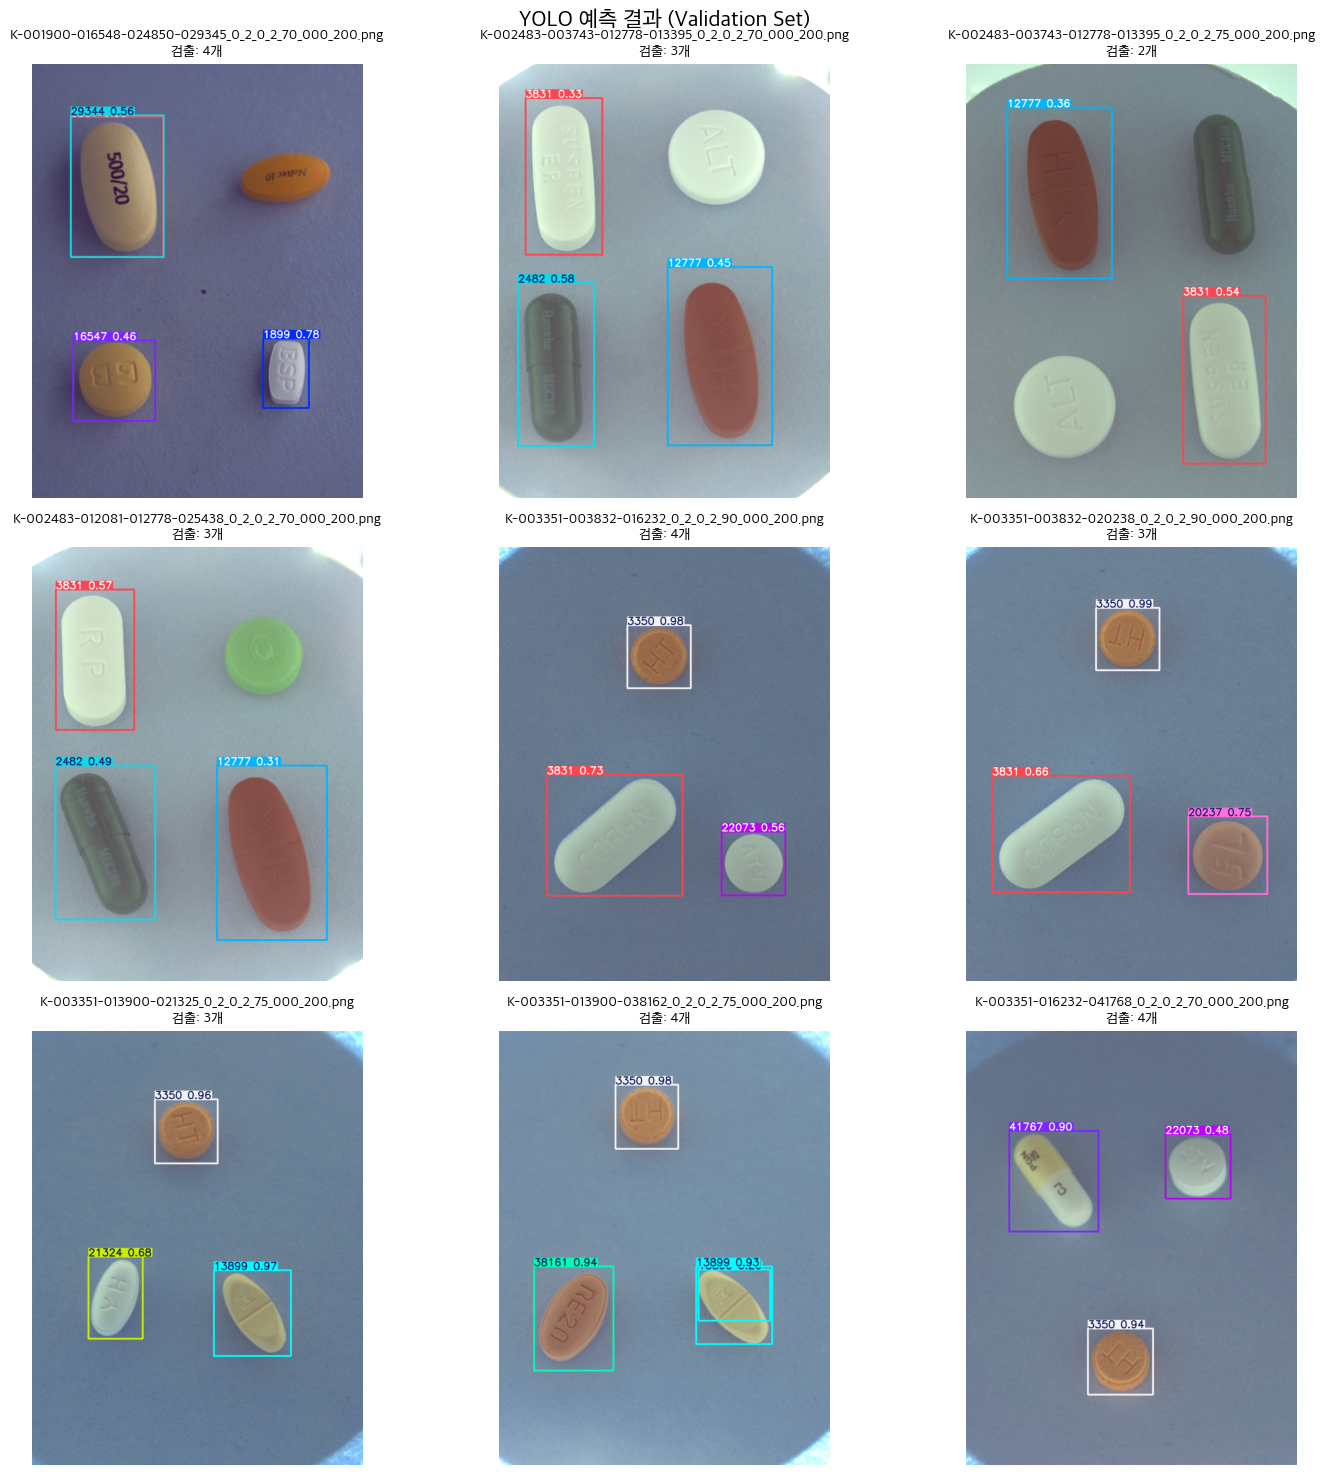

In [ ]:
import cv2
import numpy as np
from pathlib import Path

def visualize_predictions(model, num_samples=9):
    """검증 데이터에 대한 예측 결과 시각화"""
    
    val_images = sorted(glob.glob(f'{YOLO_BASE_PATH}/images/val/*.png'))[:num_samples]
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle('YOLO 예측 결과 (Validation Set)', fontsize=16, fontweight='bold')
    
    for idx, img_path in enumerate(val_images):
        # 예측
        results = model.predict(source=img_path, conf=0.25, verbose=False)[0]
        
        # 결과 이미지 가져오기
        result_img = results.plot()  # BGR format
        result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
        
        ax = axes[idx // 3, idx % 3]
        ax.imshow(result_img)
        
        # 이미지 파일명과 검출된 객체 수
        img_name = os.path.basename(img_path)
        num_detections = len(results.boxes)
        ax.set_title(f'{img_name}\n검출: {num_detections}개', fontsize=10)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# 실행
visualize_predictions(model, num_samples=9)


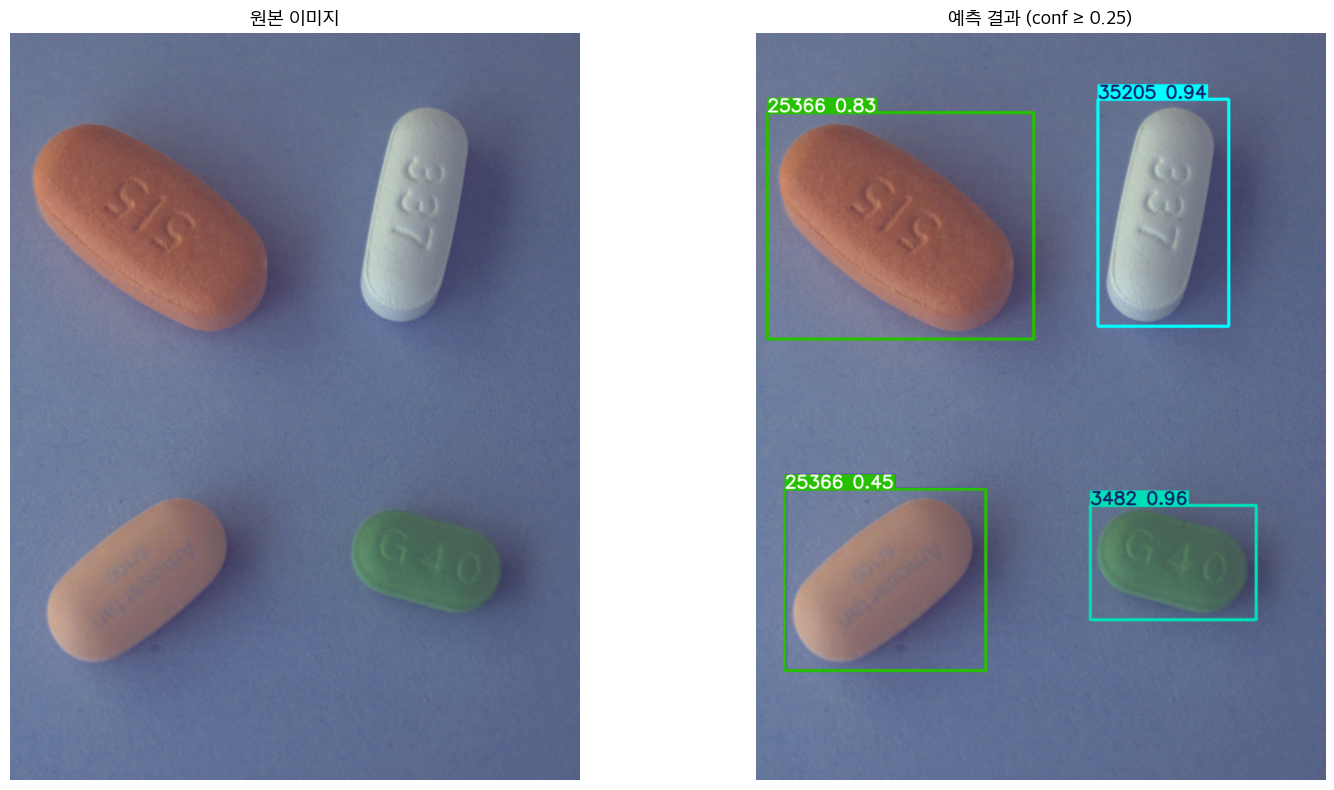


이미지: K-003483-025367-025469-035206_0_2_0_2_75_000_200.png

총 5개 객체 검출:

  [1] 3482
      • 신뢰도: 0.960
      • BBox: [572.1, 809.6, 856.3, 1005.2]

  [2] 35205
      • 신뢰도: 0.939
      • BBox: [585.2, 113.5, 809.7, 502.5]

  [3] 25366
      • 신뢰도: 0.831
      • BBox: [19.1, 136.0, 475.3, 524.7]

  [4] 25366
      • 신뢰도: 0.448
      • BBox: [49.4, 781.6, 393.5, 1092.5]

  [5] 25468
      • 신뢰도: 0.403
      • BBox: [50.6, 780.8, 393.6, 1092.6]



In [ ]:
def analyze_single_prediction(model, image_path, conf_threshold=0.25):
    """단일 이미지 예측 상세 분석"""
    
    # 예측
    results = model.predict(source=image_path, conf=conf_threshold, verbose=False)[0]
    
    # 원본 이미지
    original_img = Image.open(image_path)
    result_img = results.plot()
    result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
    
    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # 원본
    axes[0].imshow(original_img)
    axes[0].set_title('원본 이미지', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # 예측 결과
    axes[1].imshow(result_img)
    axes[1].set_title(f'예측 결과 (conf ≥ {conf_threshold})', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 상세 정보 출력
    print("\n" + "=" * 80)
    print(f"이미지: {os.path.basename(image_path)}")
    print("=" * 80)
    
    if len(results.boxes) == 0:
        print("검출된 객체 없음")
    else:
        print(f"\n총 {len(results.boxes)}개 객체 검출:\n")
        
        for i, box in enumerate(results.boxes):
            cls_id = int(box.cls[0])
            conf = float(box.conf[0])
            bbox = box.xyxy[0].cpu().numpy()
            
            class_name = idx_to_label.get(cls_id, f"Class_{cls_id}")
            
            print(f"  [{i+1}] {class_name}")
            print(f"      • 신뢰도: {conf:.3f}")
            print(f"      • BBox: [{bbox[0]:.1f}, {bbox[1]:.1f}, {bbox[2]:.1f}, {bbox[3]:.1f}]")
            print()

# 랜덤 검증 이미지 분석
import random
val_images = glob.glob(f'{YOLO_BASE_PATH}/images/val/*.png')
random_image = random.choice(val_images)
analyze_single_prediction(model, random_image, conf_threshold=0.25)